In [1]:
import numpy
%matplotlib nbagg
from matplotlib import pyplot
from tqdm import tqdm, tnrange

import aotools
from aotools.turbulence import phasescreen, infinitephasescreen
import zernike

In [2]:
def plot_temporal_power_spectrum(x_vals, power_spectra, scale, r0=None, L0=None):
    pyplot.figure()
    pyplot.grid()
    if L0 is not None:
        L0_cutoff = wind_speed/L0
        pyplot.text(L0_cutoff+0.2, 10e8, "V/L0")
        pyplot.plot([L0_cutoff, L0_cutoff], [10, 10e11], linestyle="--",linewidth=1, color="k")


    pyplot.loglog(x_vals, power_spectra.T, alpha=0.2)
    pyplot.loglog(x_vals, power_spectra.mean(0), color="blue")
    pyplot.plot(x_vals, scale * x_vals**(-8./3), color="k", linestyle=":")
    pyplot.xlabel("Frequency (Hz)")
    pyplot.ylabel("Power ($\mathrm{rad}^2$)")

In [3]:
nx_size = 256
D = 8.
pxl_scale = D/nx_size # m/pixel
r0 = 0.2
L0 = 10.
n_tests = 16
wind_speed = 10 #m/s - just arbitrarily set
n_scrns = 10000
stencil_length_factor = 16
n_columns = 2

# FFT Phase Screen

In [ ]:

total_scrn_size = stencil_length_factor * nx_size
time_step = pxl_scale/wind_speed # This is timestep, as one pixel moved on each iteration

n_scrns = total_scrn_size - nx_size

print("Time Step: {} s".format(time_step))

power_spectrum_fft = numpy.zeros((n_tests, n_scrns))

for n in tnrange(n_tests):
    print("alloc screen buffer")
    screen_buffer = numpy.zeros((n_scrns, nx_size**2))

    phase_screen = phasescreen.ft_phase_screen(r0, total_scrn_size, pxl_scale, L0, 0.01)[:, :nx_size]

    
    for i in tnrange(n_scrns):
        scrn = phase_screen[i:i+nx_size]
        if n%4 == 0:
            scrn = scrn
        elif n%4 == 1:
            scrn = scrn.T
        elif n%4 == 2:
            scrn = scrn[::-1]
        else:
            scrn = scrn[::-1].T
            
        screen_buffer[i] = scrn.flatten()

    print("Do FFT...")

    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_fft[n] = power_spectra.mean(1)


x_vals_fft = numpy.fft.fftfreq(n_scrns, d=time_step)
power_spectrum_fft = power_spectrum_fft[:, :n_scrns//2]
x_vals_fft = x_vals_fft[:n_scrns//2]

Time Step: 0.003125 s


alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...
alloc screen buffer


Do FFT...


<IPython.core.display.Javascript object>


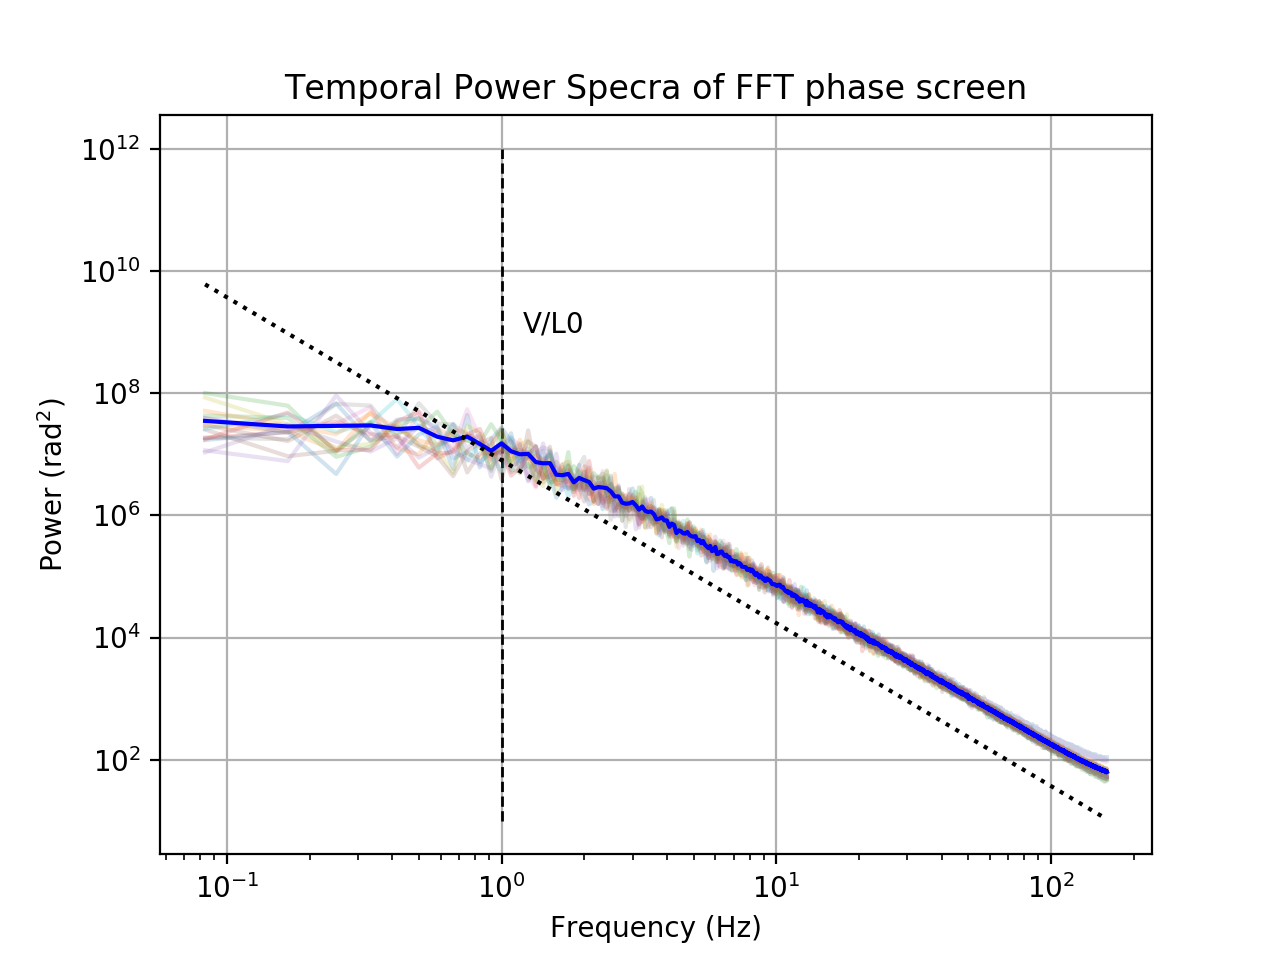

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


In [7]:
plot_temporal_power_spectrum(x_vals_fft, power_spectrum_fft, scale=8e6, r0=r0, L0=L0)
pyplot.title("Temporal Power Specra of FFT phase screen")

# Infinite Phase Screens

In [ ]:

time_step = pxl_scale/wind_speed # This is timestep, as one pixel added on each iteration

print("Time Step: {} s".format(time_step))


power_spectrum_inf = numpy.zeros((n_tests, n_scrns))

for n in tnrange(n_tests):
    print("Init phase screen")
    phase_screen = infinitephasescreen.PhaseScreenVonKarman(nx_size, pxl_scale, r0, L0, n_columns=n_columns)
    print("Total Stencil Size: {}m ({} pixels)".format(stencil_length_factor*phase_screen.nx_size * pxl_scale, phase_screen.stencil_length))

    print("alloc screen buffer")
    screen_buffer = numpy.zeros((n_scrns, nx_size**2))

    for i in tnrange(n_scrns):
        phase_screen.add_row()
        scrn = phase_screen.scrn
        if n%4 == 0:
            scrn = scrn
        elif n%4 == 1:
            scrn = scrn.T
        elif n%4 == 2:
            scrn = scrn[::-1]
        else:
            scrn = scrn[::-1].T
            
        screen_buffer[i] = scrn.flatten()

    print("Do FFT...")

    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_inf[n] = power_spectra.mean(1)


x_vals_inf = numpy.fft.fftfreq(n_scrns, d=time_step)
power_spectrum_inf = power_spectrum_inf[:, :n_scrns//2]
x_vals_inf = x_vals_inf[:n_scrns//2]


In [ ]:
plot_temporal_power_spectrum(x_vals_inf, power_spectrum_inf, scale=10e7, r0=r0, L0=L0)

In [ ]:
pyplot.figure()
pyplot.loglog(x_vals_inf_f, power_spectrum_inf_f.mean(0), label="Fried Infinite Phase Screen")
pyplot.loglog(x_vals_inf_a, power_spectrum_inf_a.mean(0), label="Assemat Infinite Phase Screen")
pyplot.loglog(x_vals_inf_a2, power_spectrum_inf_a2.mean(0), label="Assemat Infinite Phase screen (new code)")
pyplot.loglog(x_vals_fft, power_spectrum_fft.mean(0), label="FFT phase screen")

pyplot.loglog(x_vals_fft,  2e7 * (D*r0) * x_vals_fft**(-8./3), color="k", linestyle="--", linewidth=0.6)

L0_cutoff = wind_speed/L0
pyplot.text(L0_cutoff+0.2, 10e8, "V/L0")
pyplot.plot([L0_cutoff, L0_cutoff], [10, 10e11], linestyle="--",linewidth=0.6, color="k")

pyplot.legend()
pyplot.xlabel("Frequency (Hz)")
pyplot.ylabel("Power ($\mathrm{rad}^2$)")
pyplot.grid()